In [1]:
import sys
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install scipy
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install ipywidgets

In [2]:
from IPython.display import HTML

In [3]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [4]:
import numpy as np
import scipy
from scipy import integrate
from scipy import interpolate
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.widgets import Button
import matplotlib.image as mpimg
# from matplotlib.offsetbox import TextArea, DrawingArea, OffsetImage, AnnotationBbox
from matplotlib import offsetbox
from scipy import optimize
plt.ion()
plt.show()

plt.rcParams["figure.figsize"] = (10,5)
# %matplotlib inline

# some handy functions to use along widgets
from IPython.display import display, Markdown, clear_output
# widget packages
import ipywidgets as widgets

In [5]:
'''
Brachistochrone
'''



g = 10
A = (0, 0)
B = (30, -5)

ninterp = 100

class Straight:
    # y = alpha * x + beta
    def __init__(self, A, B):
        self.A = A
        self.B = B
        self.alpha = (A[1] - B[1])/(A[0] - B[0])
        self.beta = A[1] - self.alpha*A[0]
        xline = np.linspace(A[0], B[0], ninterp)
        tline = self.get_t_x_num(xline)
        # self.xinterp = interpolate.interp1d(tline, xline, kind='cubic', fill_value=(A[0], B[0]), bounds_error=False)

    def get_y_x(self, x):
        return self.alpha*x + self.beta

    def get_x_t(self, t):
        xa = self.A[0]
        ya = self.A[1]
        a = self.alpha
        b = self.beta
        x = -1./a * ( (-np.array(t)*a/2.*np.sqrt(2.*g/(1.+a*a)) + np.sqrt(-a*xa - b + ya))**2 - b + ya)
        if x < B[0]:
            return x
        else:
            return B[0]

    def get_t_x(self, x):
        xa = self.A[0]
        ya = self.A[1]
        a = self.alpha
        b = self.beta
        t = -2./a * np.sqrt((1.+a*a)/2./g) * (np.sqrt(-a*x - b + ya) - np.sqrt(-a*xa - b + ya))
        return t

    def get_dydx_x(self, x):
        return self.alpha

    def get_x_t_num(self, t):
        return self.xinterp(t)

    def get_t_x_num(self, x):
        def integrand(x):
            return np.sqrt((1+self.get_dydx_x(x)**2)/(self.A[1] - self.get_y_x(x)))
        t = 1./np.sqrt(2.*g) *np.append([0], [integrate.quad(integrand, x[0], xend)[0] for xend in x[1:]])
        return t

class Reciprocal:
    # assuming A is in (0, 0)
    # y = 1/(x + gamma) + eta
    def __init__(self, A, B):
        self.A = A
        self.B = B
        self.gamma = -B[0]/2. + np.sqrt(B[0])*np.sqrt(+4 - B[0]*B[1])/(2*np.sqrt(-B[1]))
        self.eta = - 1./self.gamma
        xline = np.linspace(A[0], B[0], 10*ninterp)
        tline = self.get_t_x(xline)
        # self.xinterp = interpolate.interp1d(np.exp(tline), np.exp(xline), kind='linear', fill_value=(A[0], B[0]), bounds_error=False)
        self.xinterp = interpolate.interp1d(tline, xline, kind='quadratic', fill_value=(A[0], B[0]), bounds_error=False)

    def get_y_x(self, x):
        return 1./(x + self.gamma) + self.eta

    def get_dydx_x(self, x):
        return -1./(x + self.gamma)**2

    def get_x_t(self, t):
        # return np.log(self.xinterp(np.exp(np.array(t))))
        return self.xinterp(np.array(t))

    # plt.clf()
    # plt.plot(tline, xline)
    # testx = np.log(xinterp(np.exp(np.array(tline))))
    # plt.plot(tline, testx)
    #
    # testx = np.log(xinterp(np.exp(np.array(time))))
    # plt.plot(time, testx)

    def get_t_x(self, x):
        def integrand(x):
            return np.sqrt((1+self.get_dydx_x(x)**2)/(self.A[1] - self.get_y_x(x)))
        t = 1./np.sqrt(2.*g) * np.append([0], [integrate.quad(integrand, x[0], xend)[0] for xend in x[1:]])
        return t


class Polynom2nd:
    # assuming A is in (0, 0)
    # y = ax^2 + bx + c
    def __init__(self, A, B, a):
        self.A = A
        self.B = B
        self.a = a
        self.b = (B[1] - self.a*B[0]**2)/B[0]
        self.c = 0
        xline = np.linspace(A[0], B[0], ninterp)
        tline = self.get_t_x(xline)
        self.xinterp = interpolate.interp1d(tline, xline, kind='cubic', fill_value=(A[0], B[0]), bounds_error=False)

    def get_y_x(self, x):
        return self.a*x**2 + self.b*x + self.c

    def get_dydx_x(self, x):
        return 2*self.a*x + self.b

    def get_x_t(self, t):
        return self.xinterp(np.array(t))

    def get_t_x(self, x):
        def integrand(x):
            return np.sqrt((1+self.get_dydx_x(x)**2)/(self.A[1] - self.get_y_x(x)))
        t = 1./np.sqrt(2.*g) * np.append([0], [integrate.quad(integrand, x[0], xend)[0] for xend in x[1:]])
        return t

class Cycloid:
    # assuming A is in (0, 0)
    def __init__(self, A, B):
        self.A = A
        self.B = B
        self.Phi = optimize.fsolve(self.eq_phi, 0.5)[0]
        self.r = B[0]/(self.Phi - np.sin(self.Phi))
        philine = np.linspace(0, self.Phi, 10*ninterp)
        xline = self.r*(philine - np.sin(philine))
        yline = self.r*(1 - np.cos(philine))
        self.xinterp = interpolate.interp1d(yline, xline, kind='cubic', fill_value=(A[1], B[1]), bounds_error=False)
        self.yinterp = interpolate.interp1d(xline, yline, kind='cubic', fill_value=(A[1], B[1]), bounds_error=False)
        # self.phi_x_interp = interpolate.interp1d(xline, philine, kind='cubic', fill_value=(A[1], B[1]), bounds_error=False)
        # self.phi_y_interp = interpolate.interp1d(yline, philine, kind='cubic', fill_value=(A[1], B[1]), bounds_error=False)
    # def get_x_y(self, y):
    #     return self.r*np.arccos(1. + y/self.r) - np.sqrt(-2.*self.r*y-y*y)

        # self.phi_x_interp = interpolate.interp1d(xline, self.get_phi_x(xline), kind='cubic', fill_value=(A[1], B[1]), bounds_error=False)
        tline = philine/np.sqrt(g/self.r)
        self.tinterp = interpolate.interp1d(xline, tline, kind='cubic', fill_value=(A[1], B[1]), bounds_error=False)

    def eq_phi(self, phi):
        ans = -B[1]/B[0] - (1 - np.cos(phi))/(phi - np.sin(phi))
        return ans

    def get_phi_y(self, y):
        phi = np.arccos((1 - y/self.r))
        return phi

    def get_phi_x(self, x):
        y = self.get_y_x(x)
        phi = x/self.r + np.sqrt(-2*self.r*y-y*y)/self.r
        return phi

    def get_x_y(self, y):
        return self.xinterp(y)

    def get_y_x(self, x):
        return -self.yinterp(x)

    def get_x_t(self, t):
        phi = np.sqrt(g/self.r)*np.array(t)
        return self.r*(phi - np.sin(phi))

    # def get_y(self, t):
    #     phi = np.sqrt(g/self.r)*np.array(t)
    #     return self.r*(1 - np.cos(phi))

    def get_t_x(self, x):
        # tend = self.Phi/np.sqrt(g/self.r)
        # t = self.get_phi_x(x)/np.sqrt(g/self.r)
        # t = np.sqrt(self.r/g)*self.phi_x_interp(x)
        t = self.tinterp(x)
        return t


xline = np.linspace(A[0], B[0], 200)

cycfunc = Cycloid(A, B)
cyc_y_x = cycfunc.get_y_x(xline)
cyc_t_x = cycfunc.get_t_x(xline)

strfunc = Straight(A, B)
str_y_x = strfunc.get_y_x(xline)
str_t_x = strfunc.get_t_x(xline)
str_t_x_num = strfunc.get_t_x_num(xline)

recfunc = Reciprocal(A, B)
rec_y_x = recfunc.get_y_x(xline)
rec_t_x = recfunc.get_t_x(xline)


# polfunc = Polynom2nd(A, B, 0.05)
# pol_y_x = polfunc.get_y_x(xline)
# pol_t_x = polfunc.get_t_x(xline)



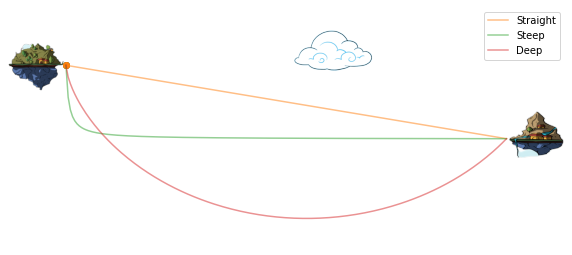

In [6]:

def init():
    point_cyc.set_data(A[0], A[1])
    point_rec.set_data(A[0], A[1])
    point_str.set_data(A[0], A[1])
    plt.xlim(A[0]-4, B[0]+4)
    plt.ylim(np.amin([str_y_x, rec_y_x, cyc_y_x])-2, 4)
    return [point_cyc, point_rec, point_str]
    
def data_gen(fps, tend):
    gen_list = ([t] for t in np.linspace(0, tend, tend*fps))
    # gen_list = np.array([t for t in np.linspace(0, tend, tend*fps)])
    return gen_list
    
def run(time):
    str_x_t = strfunc.get_x_t(time)
    rec_x_t = recfunc.get_x_t(time)
    cyc_x_t = cycfunc.get_x_t(time)
    # pol_x_t = polfunc.get_x_t(time)

    str_x_t = B[0] if str_x_t>B[0] else str_x_t
    cyc_x_t = B[0] if cyc_x_t>B[0] else cyc_x_t


    str_yi = strfunc.get_y_x(str_x_t)
    rec_yi = recfunc.get_y_x(rec_x_t)
    cyc_yi = cycfunc.get_y_x(cyc_x_t)
    # pol_yi = polfunc.get_y_x(pol_x_t)

    plt.xlim(A[0]-4, B[0]+4)
    plt.ylim(np.amin([str_y_x, rec_y_x, cyc_y_x])-2, 4)

    ax.figure.canvas.draw()

    point_cyc.set_data(cyc_x_t, cyc_yi) #, label="deep, time=%.1f"%time_pol)
    point_rec.set_data(rec_x_t, rec_yi) #, label="steep, time=%.1f"%time_rec)
    point_str.set_data(str_x_t, str_yi) #, label="straight, time=%.1f"%time_str)

    # point_pol.set_data(pol_x_t, pol_yi) #, label="deep, time=%.1f"%time_pol)

    return [point_cyc, point_rec, point_str]



fig, ax = plt.subplots(figsize=[10, 5])

plt.axis('off')

arr_floatinghouse1 = mpimg.imread('images/floatinghouse1.png')
arr_floatinghouse2 = mpimg.imread('images/floatinghouse2.png')
arr_floatinghouse3 = mpimg.imread('images/floatinghouse3.png')
arr_cloud = mpimg.imread('images/Clouds-07.png')

ax.imshow(arr_floatinghouse1, extent=[A[0]-4, A[0]+0.1, A[1]-2, A[1]+2])
ax.imshow(arr_floatinghouse2, extent=[B[0]-0.1, B[0]+4, B[1]-1.6, B[1]+2.1])
ax.imshow(arr_cloud, extent=[(-A[0]+B[0])/2., (-A[0]+B[0])/2.+6, A[1]-2, A[1]+4])
# ax.imshow(arr_cloud, extent=[(-A[0]+B[0])/2.-6, (-A[0]+B[0])/2.-3, A[1]+1, A[1]+4])

point_cyc, = ax.plot([A[0]], [A[1]], 'o', color="C3", alpha=1)
point_rec, = ax.plot([A[0]], [A[1]], 'o', color="C2", alpha=1)
point_str, = ax.plot([A[0]], [A[1]], 'o', color="C1", alpha=1)


# point_pol, = ax.plot([A[0]], [A[1]], 'o', color="C4")
# point_pol.set_data(A[0], A[1])

plt.plot(xline, str_y_x, label="Straight", color='C1', alpha=0.5)
plt.plot(xline, rec_y_x, label="Steep", color='C2', alpha=0.5)
plt.plot(xline, cyc_y_x, label="Deep", color='C3', alpha=0.5)
# plt.plot(xline, pol_y_x, label="Deep", color='C4')
# ax.grid()
ax.legend(loc=1)

plt.xlim(A[0]-4, B[0]+4)
plt.ylim(np.amin([str_y_x, rec_y_x, cyc_y_x])-2, 4)


tend = 6 # seconds
fps = 10
interval = 10
class Index:
    def __init__(self):
        self.running = False
        self.anim = None

    def run(self, event):
        if self.anim is None:
            self.running = True
            self.anim = animation.FuncAnimation(fig, run, data_gen(fps, tend), interval=interval, init_func=init, blit=True)
            # Writer = animation.writers['ffmpeg']
            # writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)
            # self.anim.save('freefall.mp4', writer=writer)
        elif self.running is True:
            self.anim.event_source.stop()
            self.running = False
        else:
            self.anim.event_source.start()
            self.running = True

    def reset(self, event):
        self.anim.frame_seq = self.anim.new_frame_seq()
        # self.anim.event_source.stop()
        # self.anim = animation.FuncAnimation(fig, run, data_gen(fps, tend), interval=interval, init_func=init)
        # self.running = True

callback = Index()
# axrun = plt.axes([0.4, 0.75, 0.15, 0.075])
# brun = Button(axrun, 'Start/Stop')
# brun.on_clicked(callback.run)

